# **Librerías y carga de datos**
En esta sección se importan todas las libreríaas que son necesarias para la limpieza y transformación de los datos.

In [1]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np
import requests
from io import StringIO

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Gestión de librerías
# ==============================================================================
from importlib import reload


# Preparación de datos
# ==============================================================================
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import joblib

# Modelos
# ==============================================================================
from sklearn.cluster import KMeans
import hdbscan
from sklearn.metrics import silhouette_score
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import SpectralClustering

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from geopy.distance import great_circle
import folium
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
from branca.element import Template, MacroElement
!pip install selenium
from selenium import webdriver
from PIL import Image
import time
import os
from PIL import Image

# Conexion Drive
# ==============================================================================
from google.colab import drive
drive.mount('/content/drive')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.2/499.2 kB 25.6 MB/s eta 0:00:00
Mounted at /content/drive


# **Modelo con no normalizados**


In [2]:
# Importar datos
# ==============================================================================
df = pd.read_csv('/content/drive/MyDrive/Monografia Especializacion/Datasets/hurtos_decod.csv')
df.info()
df = df[['latitud', 'longitud']]
df = df.sample(n=25000, random_state=42)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492988 entries, 0 to 492987
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   latitud         492988 non-null  float64
 1   longitud        492988 non-null  float64
 2   sexo            492988 non-null  int64  
 3   edad            492988 non-null  int64  
 4   estado_civil    492988 non-null  int64  
 5   conducta        492988 non-null  int64  
 6   modalidad       492988 non-null  int64  
 7   arma_medio      492988 non-null  int64  
 8   codigo_comuna   492988 non-null  int64  
 9   lugar           492988 non-null  int64  
 10  categoria_bien  492988 non-null  int64  
 11  día             492988 non-null  int64  
 12  mes             492988 non-null  int64  
 13  zona            492988 non-null  int64  
 14  rango_hora      492988 non-null  int64  
dtypes: float64(2), int64(13)
memory usage: 56.4 MB


min_cluster_size: 100 con cantidad de clusters: 2
min_cluster_size: 120 con cantidad de clusters: 2
min_cluster_size: 140 con cantidad de clusters: 2
min_cluster_size: 160 con cantidad de clusters: 2
min_cluster_size: 180 con cantidad de clusters: 4
min_cluster_size: 200 con cantidad de clusters: 4
min_cluster_size: 220 con cantidad de clusters: 4
min_cluster_size: 240 con cantidad de clusters: 4
min_cluster_size: 260 con cantidad de clusters: 5
min_cluster_size: 280 con cantidad de clusters: 3
min_cluster_size: 300 con cantidad de clusters: 4
min_cluster_size: 320 con cantidad de clusters: 4
min_cluster_size: 340 con cantidad de clusters: 4
min_cluster_size: 360 con cantidad de clusters: 4
min_cluster_size: 380 con cantidad de clusters: 4
min_cluster_size: 400 con cantidad de clusters: 3
min_cluster_size: 420 con cantidad de clusters: 3
min_cluster_size: 440 con cantidad de clusters: 3
min_cluster_size: 460 con cantidad de clusters: 3
min_cluster_size: 480 con cantidad de clusters: 3


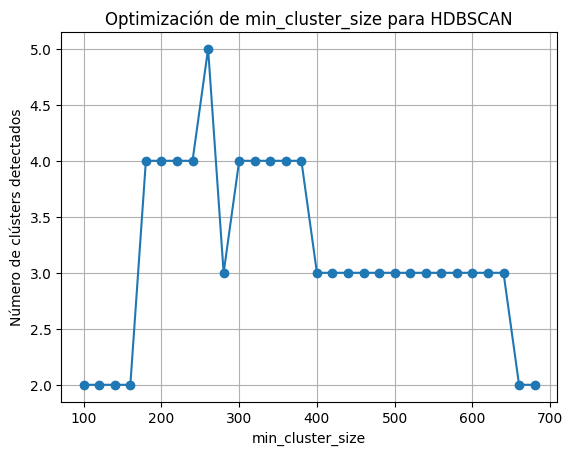

In [ ]:
# Encontrar valor optimo para min_cluster_size
# ==============================================================================
min_sizes = range(100, 700, 20)
n_clusters = []

for size in min_sizes:
    clusterer = hdbscan.HDBSCAN(min_cluster_size=size)

    clusterer.fit_predict(df)  # X es tu matriz de datos
    labels = clusterer.labels_
    n_clusters.append(len(set(labels)) - (1 if -1 in labels else 0))
    print(f"min_cluster_size: {size} con cantidad de clusters: {len(set(labels)) - (1 if -1 in labels else 0)}")

plt.plot(min_sizes, n_clusters, marker='o')
plt.xlabel("min_cluster_size")
plt.ylabel("Número de clústers detectados")
plt.title("Optimización de min_cluster_size para HDBSCAN")
plt.grid(True)
plt.show()

In [ ]:
# Modelado
# ==============================================================================

# hdbscan
dbscan = hdbscan.HDBSCAN(min_cluster_size=260)
df['cluster'] = dbscan.fit_predict(df)

# Análisis de los clusters
cluster_summary = df.groupby('cluster').mean()

print("Resumen por cluster:")
print(cluster_summary)


Resumen por cluster:
          latitud   longitud
cluster                     
-1       6.252694 -75.578579
 0       6.209500 -75.574785
 1       6.290367 -75.571298
 2       6.233979 -75.599507
 3       6.252336 -75.589432
 4       6.250477 -75.566661


In [ ]:
# visualizacion
# ==============================================================================


df_dots = df[["latitud", "longitud", "cluster"]]
df_dots = df_dots[df_dots["cluster"] != -1]

#df_dots[["latitud", "longitud"]]  = scaler.inverse_transform(df_dots[["latitud", "longitud"]])

# Crear mapa interactivo
mapa = folium.Map(location=[6.2442, -75.5812], zoom_start=12)

# Obtener una lista de colores desde una paleta de Matplotlib
num_clusters = df_dots['cluster'].nunique()
colormap = plt.cm.get_cmap('Dark2', num_clusters)

# Crear un diccionario que mapea cada número de clúster a un color hexadecimal
cluster_colors = {cluster: mcolors.rgb2hex(colormap(i)[:3]) for i, cluster in enumerate(df_dots['cluster'].unique())}

# Agregar TODOS los puntos de hurtos al mapa
for _, row in df_dots.iterrows():
    folium.CircleMarker(
        location=[row["latitud"], row["longitud"]],
        radius=0.7,  # Tamaño fijo del círculo
        color=cluster_colors[row['cluster']],
        fill=True,
        fill_color=cluster_colors[row['cluster']],
        fill_opacity=0.3,
        alpha=0.6
    ).add_to(mapa)

# Agregar leyenda
legend_html = """
{% macro html(this, kwargs) %}
<div style="
    position: fixed;
    bottom: 50px;
    left: 50px;
    width: 180px;
    height: auto;
    z-index:9999;
    font-size:14px;
    background-color: white;
    padding: 10px;
    border:2px solid grey;
    border-radius: 5px;
">
    <b>Clusters</b><br>
    """ + "".join([
        f'<i style="background:{color};width:10px;height:10px;display:inline-block;margin-right:5px"></i> Cluster {cluster}<br>'
        for cluster, color in cluster_colors.items()
    ]) + """
</div>
{% endmacro %}
"""

legend = MacroElement()
legend._template = Template(legend_html)
mapa.get_root().add_child(legend)

mapa




Output hidden; open in https://colab.research.google.com to view.

# **Modelo - Evolucion anual**


In [3]:
# Importar datos
# ==============================================================================
df = pd.read_csv('/content/drive/MyDrive/Monografia Especializacion/Datasets/hurtos_original_con año.csv')
df.info()
#df = df[['latitud', 'longitud']]
#df = df.sample(n=25000, random_state=42)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492988 entries, 0 to 492987
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   latitud         492988 non-null  float64
 1   longitud        492988 non-null  float64
 2   sexo            492988 non-null  object 
 3   edad            492988 non-null  int64  
 4   estado_civil    492988 non-null  object 
 5   conducta        492988 non-null  object 
 6   modalidad       492988 non-null  object 
 7   arma_medio      492988 non-null  object 
 8   codigo_comuna   492988 non-null  int64  
 9   lugar           492988 non-null  object 
 10  categoria_bien  492988 non-null  object 
 11  año             492988 non-null  int64  
 12  día             492988 non-null  int64  
 13  mes             492988 non-null  int64  
 14  zona            492988 non-null  object 
 15  rango_hora      492988 non-null  object 
dtypes: float64(2), int64(5), object(9)
memory usage: 60.2+ M

In [4]:
years = df['año'].unique()
years = np.sort(years)
years

array([2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022])

In [5]:
# creado de dataframes y modelado
# ==============================================================================
data = []
for i in years:
  df_year = df[df['año'] == i][['año', 'latitud', 'longitud']]
  data.append(df_year)


In [34]:

data_model = []

min_cluster_sizes = [
    150,  # 0
    150,  # 1
    150,  # 2
    68,  # 3
    146,  # 4
    100,  # 5
    100,  # 6
    80,  # 7
    50,  # 8
    100,  # 9
    110,  # 10
    160,  # 11
    57,  # 12
    114,  # 13
    90,  # 14
    125,  # 15
    185,  # 16
    55,  # 17
    123,  # 18
    140   # 19
]


for i, n in zip(data, min_cluster_sizes) :
  dbscan = hdbscan.HDBSCAN(min_cluster_size=n)
  year = i['año'].unique()
  print(f'modelo realizado: {year}')
  i['cluster'] = dbscan.fit_predict(i[['latitud', 'longitud']])
  i = i[i["cluster"] != -1]
  data_model.append(i)

modelo realizado: [2003]
modelo realizado: [2004]
modelo realizado: [2005]
modelo realizado: [2006]
modelo realizado: [2007]
modelo realizado: [2008]
modelo realizado: [2009]
modelo realizado: [2010]
modelo realizado: [2011]
modelo realizado: [2012]
modelo realizado: [2013]
modelo realizado: [2014]
modelo realizado: [2015]
modelo realizado: [2016]
modelo realizado: [2017]
modelo realizado: [2018]
modelo realizado: [2019]
modelo realizado: [2020]
modelo realizado: [2021]
modelo realizado: [2022]


In [35]:


mapas = []

for df in data_model:
    df_dots = df[["latitud", "longitud", "cluster"]]
    year = df['año'].unique()
    print(f'mapa realizado: {year}')
    if df_dots.empty:
        continue  # Saltar si no hay datos (todos eran ruido)

    # Crear mapa base
    mapa = folium.Map(location=[df_dots["latitud"].mean(), df_dots["longitud"].mean()], zoom_start=12)

    # Colores
    num_clusters = df_dots['cluster'].nunique()
    colormap = plt.cm.get_cmap('Dark2', num_clusters)
    cluster_colors = {cluster: mcolors.rgb2hex(colormap(i)[:3]) for i, cluster in enumerate(df_dots['cluster'].unique())}

    # Puntos al mapa
    for _, row in df_dots.iterrows():
        folium.CircleMarker(
            location=[row["latitud"], row["longitud"]],
            radius=0.7,
            color=cluster_colors[row['cluster']],
            fill=True,
            fill_color=cluster_colors[row['cluster']],
            fill_opacity=0.3,
            alpha=0.6
        ).add_to(mapa)

    # Leyenda
    legend_html = """
    {% macro html(this, kwargs) %}
    <div style="
        position: fixed;
        bottom: 50px;
        left: 50px;
        width: 180px;
        height: auto;
        z-index:9999;
        font-size:14px;
        background-color: white;
        padding: 10px;
        border:2px solid grey;
        border-radius: 5px;
    ">
        <b>Clusters</b><br>
    """ + "".join([
        f'<i style="background:{color};width:10px;height:10px;display:inline-block;margin-right:5px"></i> Cluster {cluster}<br>'
        for cluster, color in cluster_colors.items()
    ]) + """
    </div>
    {% endmacro %}
    """

    legend = MacroElement()
    legend._template = Template(legend_html)
    mapa.get_root().add_child(legend)

    # Agregar a la lista
    mapas.append(mapa)


mapa realizado: [2003]
mapa realizado: [2004]
mapa realizado: [2005]
mapa realizado: [2006]
mapa realizado: [2007]
mapa realizado: [2008]
mapa realizado: [2009]
mapa realizado: [2010]
mapa realizado: [2011]
mapa realizado: [2012]
mapa realizado: [2013]
mapa realizado: [2014]
mapa realizado: [2015]
mapa realizado: [2016]
mapa realizado: [2017]
mapa realizado: [2018]
mapa realizado: [2019]
mapa realizado: [2020]
mapa realizado: [2021]
mapa realizado: [2022]


In [32]:
# Instalar las dependencias necesarias
!apt-get update -q
!apt-get install -y wget curl unzip
!apt-get install -y chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!chmod +x /usr/bin/chromedriver
!apt install -y python3-opencv

# Instalar el paquete de Selenium
!pip install -q selenium

# Configuración de Selenium para usar Chrome en modo headless
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import time
from PIL import Image
import matplotlib.pyplot as plt
import tempfile
import os



Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,901 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,546 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 P

In [36]:
# Configurar Chrome para ejecutarse sin cabeza (sin interfaz gráfica)
options = Options()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
options.add_argument(f'--user-data-dir={tempfile.mkdtemp()}')


driver = webdriver.Chrome( options=options)

image_files = []

# Asumiendo que `mapas` es tu lista de mapas que deseas guardar y convertir en imágenes
for idx, mapa in enumerate(mapas):
    file_path = f'mapa_{idx}.html'
    mapa.save(file_path)

    driver.get("file://" + os.path.abspath(file_path))
    time.sleep(2)  # Esperar a que cargue


    screenshot_path = f'mapa_{idx}.png'
    driver.save_screenshot(screenshot_path)
    image_files.append(screenshot_path)

# Cerrar el navegador
driver.quit()

# Crear el collage de imágenes
n = len(image_files)
cols = 2
rows = (n + 1) // cols

fig, axs = plt.subplots(rows, cols, figsize=(12, 6 * rows))

for i, path in enumerate(image_files):
    img = Image.open(path)
    ax = axs[i // cols, i % cols] if rows > 1 else axs[i % cols]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Año: {years[i]}", fontsize=14)

plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.